# **Modelling and Evaluation Notebook**

## Objectives

* Answer business requirement 2:
    * Deliver an ML system that is capable of predicting whether a cherry leaf is healthy or contains powdery mildew. 

## Inputs

* inputs/mildew_dataset/leaves_images/train
* inputs/mildew_dataset/leaves_images/test
* inputs/mildew_dataset/leaves_images/validation
* image shape embeddings.

## Outputs

* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.


## Additional Comments

* No additional comments.



---

## Import regular packages

In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Dropout, Flatten, Dense, BatchNormalization, MaxPooling2D
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import cv2

## Set Working Directory

In [16]:
cwd= os.getcwd()

In [17]:
os.chdir('/workspace/mildew-detection')
print("You set a new current directory")

You set a new current directory


In [18]:
work_dir = os.getcwd()
work_dir

'/workspace/mildew-detection'

## Set output directory

In [20]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


## Set image shape

In [21]:
from tensorflow.keras.preprocessing.image import load_img

sample_image_path = train_df['file'].iloc[0]
sample_image = load_img(sample_image_path)
image_shape = sample_image.size + (3,)
print("Image Shape:", image_shape)

Image Shape: (256, 256, 3)


---

## Number of images in train, test and validation DataFrames

Calculate and plot how many images

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




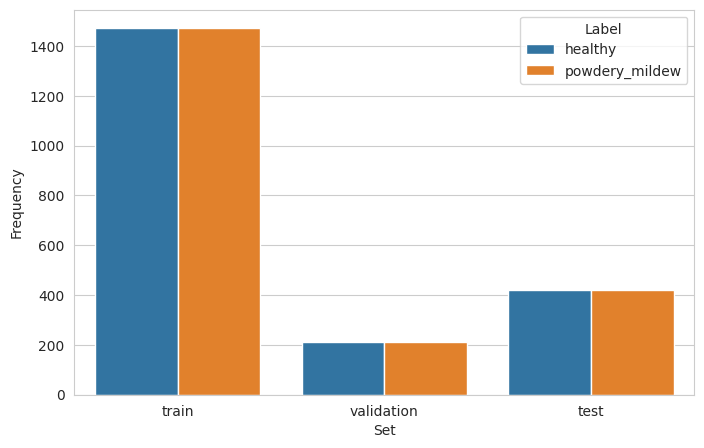

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming train_df, validation_df, and test_df are defined DataFrames with a 'label' column
# Example:
# train_df = pd.DataFrame({'filename': ['img1.jpg', 'img2.jpg'], 'label': ['label1', 'label2']})
# validation_df = pd.DataFrame({'filename': ['img3.jpg', 'img4.jpg'], 'label': ['label1', 'label2']})
# test_df = pd.DataFrame({'filename': ['img5.jpg', 'img6.jpg'], 'label': ['label1', 'label2']})

# Combine all labels from the datasets to get the unique labels
all_labels = pd.concat([train_df['label'], validation_df['label'], test_df['label']])
labels = all_labels.unique()

# Initialize an empty DataFrame
df_freq = pd.DataFrame([])

# Define the datasets
datasets = [('train', train_df), ('validation', validation_df), ('test', test_df)]

# Iterate over each dataset and label to count the occurrences
for dataset_name, dataset_df in datasets:
    for label in labels:
        # Count the number of occurrences of the label in the current dataset
        label_count = dataset_df[dataset_df['label'] == label].shape[0]

        # Append the count to the df_freq DataFrame
        df_freq = df_freq.append(
            pd.Series(data={'Set': dataset_name,
                            'Label': label,
                            'Frequency': label_count}),
            ignore_index=True
        )

        # Print the count
        print(f"* {dataset_name} - {label}: {label_count} images")

print("\n")

# Plot the frequency distribution
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

---

## Image data augmentation

---

### ImageDataGenerator

In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Initialize ImageDataGenerator

In [40]:
data_dir = 'inputs/datasets'
train_path = data_dir + '/train'
validation_path = data_dir + '/validation'
test_path = data_dir + '/test'

In [39]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

In [32]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

In [41]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

In [42]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot augmented training image

(20, 256, 256, 3)


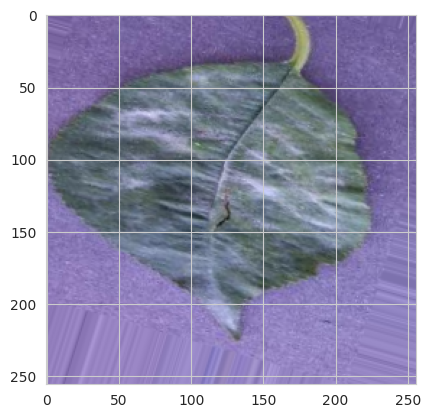

(20, 256, 256, 3)


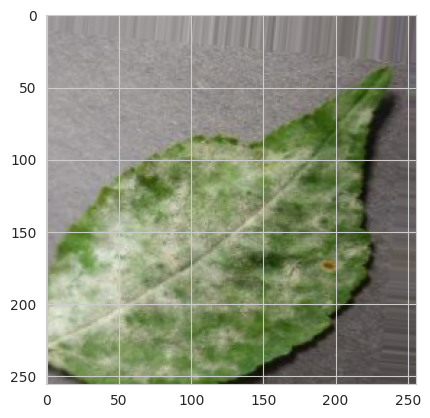

(20, 256, 256, 3)


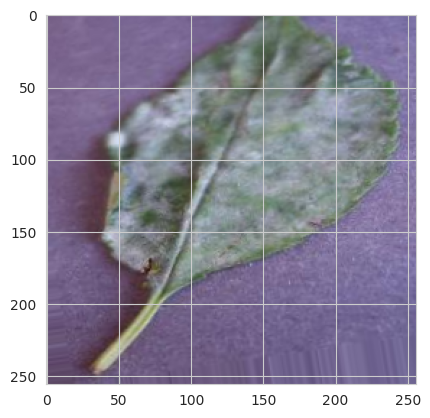

In [43]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

## Plot augmented validation and test images

(20, 256, 256, 3)


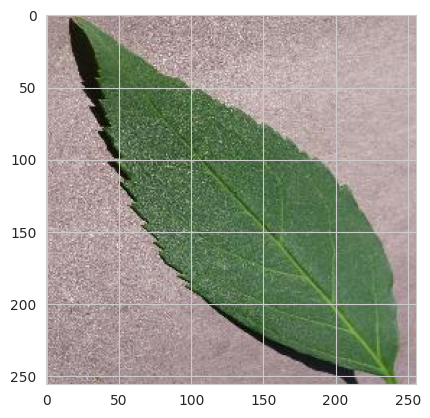

(20, 256, 256, 3)


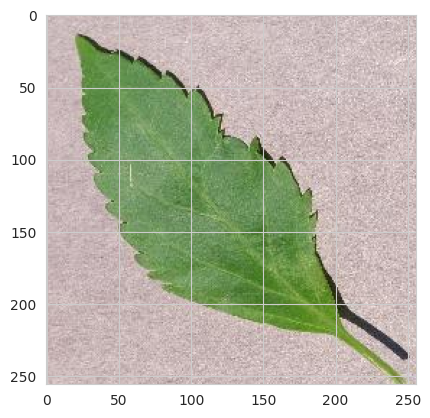

(20, 256, 256, 3)


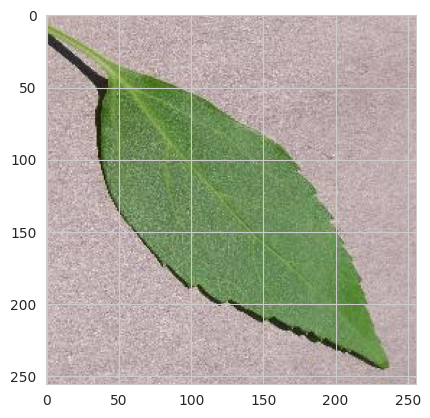

(20, 256, 256, 3)


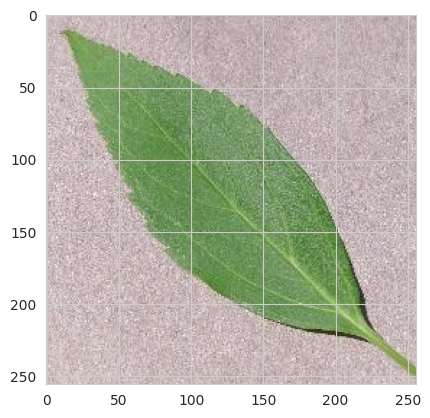

(20, 256, 256, 3)


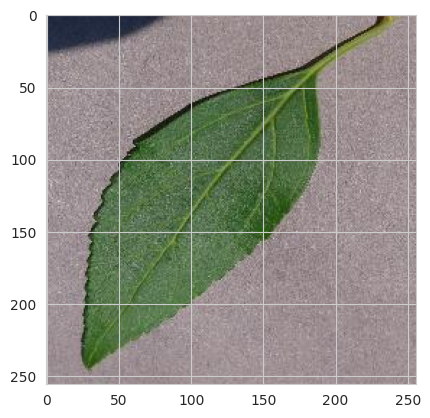

(20, 256, 256, 3)


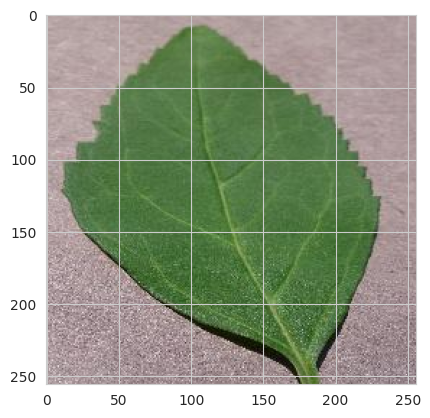

In [44]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()
    
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

## Save

In [ ]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

---

# Model creation

---

## ML Model

### Import model packages

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

## Model

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=image_shape))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [53]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [54]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 60, 60, 16)        4624      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 14400)            

### Early stopping

In [55]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

## Fit model for model training

In [56]:
model = create_mildew_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

NameError: name 'filters' is not defined

## Plot augmented training image

In [ ]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

## Save model

In [ ]:

model.save('outputs/v1/mildew_detection_model.h5')

---

# Model Performace

---

## Model learning curve

In [ ]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Model Evaluation

In [ ]:
from keras.models import load_model
model = load_model('outputs/v1/mildew_detection_model.h5')

Evaluate model on test set

### Save evaluation pickle

In [ ]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

## Predict on new data

Load a random image as PIL

In [ ]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[0]  # select Uninfected or Parasitised

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert image to array and prepare for prediction

In [ ]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

Predict class probabilities

In [ ]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

# Push files to Repo

* If you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
    # create here your folder
    # os.makedirs(name='')
except Exception as e:
    print(e)
